In [1]:
import pandas as pd
import numpy as np
import os

import glob
import re
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import scipy
import nideconv
from nideconv import GroupResponseFitter

import pickle as pkl
import matplotlib.pyplot as plt

%load_ext rpy2.ipython
%matplotlib inline

In [2]:
# load events, confounds, timeseries df
events = pd.read_pickle('./derivatives/all_subjects_events.pkl')
confounds = pd.read_pickle('./derivatives/all_subjects_confounds.pkl')
df = pd.read_pickle('./derivatives/all_subjects_stn_timeseries.pkl')

events['onset'] -= 1.5  # STC

# Fit GLM with canonical HRF

### Following GdH's PhD thesis, we fit 4 different GLMs:
1. GLM1: (a) neutral cue, (b) payoff cue, (c) easy stimulus, and (d) hard stimulus. Its first main contrast of interest was ‘payoff cue > neutral cue’, the other main contrast was ‘hard stimulus > easy stimulus’
2. GLM2: (a) neutral cue, (b) payoff cue (left), (c) payoff cue (right), (d) easy stimulus, and (e) hard stimulus. The contrast of interest was “payoff cue (left) > payoff cue (right)”.
3. GLM3: (a) neutral cue, (b) payoff cue, (d) easy stimulus (correct), (e) easy stimulus (error), (f) hard stimulus (correct), and (g) hard stimulus (error). The main contrast: ‘hard stimulus (correct) > easy stimulus (correct)’
4. GLM4: (a) neutral cue, (b) potential payoff cue, (c) easy trials, (d) hard trials, (e) left responses, and (f) right responses. Contrast: Lateralization.

# GLM 1

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


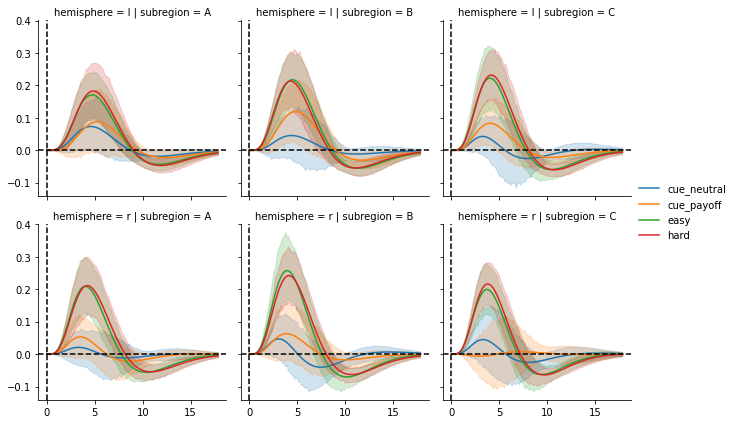

In [3]:
events_1 = events.loc[events['event_type'].isin(['easy', 'hard', 'cue_left', 'cue_right', 'cue_neutral'])]
events_1.loc[events_1['event_type'].isin(['cue_left', 'cue_right']), 'event_type'] = 'cue_payoff'

glm1 = GroupResponseFitter(df.copy(),
                            events_1, 
                            confounds=confounds,
                            input_sample_rate=1/3, 
                            oversample_design_matrix=20, 
                            concatenate_runs=True)
for event_type in events_1.event_type.unique():
    glm1.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])

glm1.fit()

# get timecourses
tc = glm1.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('_').apply(lambda x: x[1])
tc['subregion'] = tc['roi'].str.split('_').apply(lambda x: x[2])

# plot
fac = sns.FacetGrid(tc, row='hemisphere', col='subregion')
fac.map_dataframe(sns.lineplot, x='time', hue='event type', y='signal', color=sns.color_palette())
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')
fac.add_legend()

### Statistics

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


,mask,t,p,p.fdr,contrast
0,signal_l_A,0.570524,0.572307,0.686768,glm1_cue
1,signal_l_B,2.107619,0.042989,0.128967,glm1_cue
2,signal_l_C,2.241181,0.032081,0.128967,glm1_cue
3,signal_r_A,0.889021,0.380627,0.570940,glm1_cue
4,signal_r_B,1.511865,0.140382,0.280764,glm1_cue
5,signal_r_C,-0.279022,0.782024,0.782024,glm1_cue


,mask,t,p,p.fdr,contrast
0,signal_l_A,-0.598420,0.553772,0.830749,glm1_difficulty
1,signal_l_B,0.366359,0.716509,0.830749,glm1_difficulty
2,signal_l_C,-0.525316,0.602985,0.830749,glm1_difficulty
3,signal_r_A,-0.492335,0.625843,0.830749,glm1_difficulty
4,signal_r_B,-0.215495,0.830749,0.830749,glm1_difficulty
5,signal_r_C,-0.626680,0.535315,0.830749,glm1_difficulty


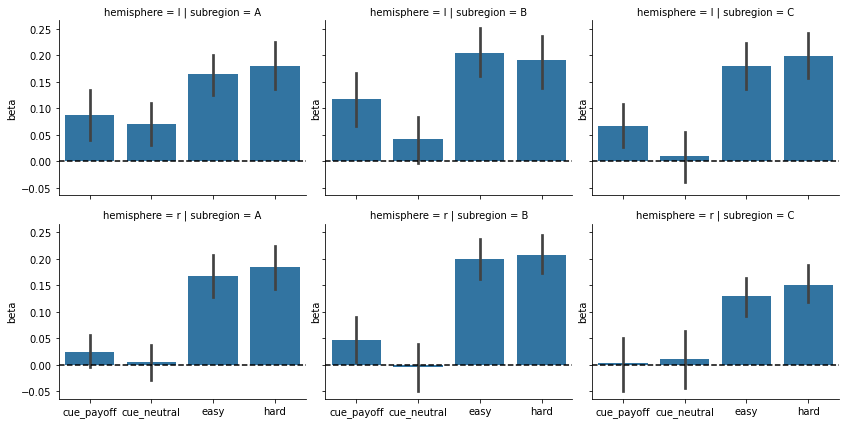

In [4]:
# extract all betas
GLM1_betas = pd.concat(glm1.concat_response_fitters.apply(lambda x: x.betas).values)
GLM1_betas = GLM1_betas.loc[(['cue_payoff', 'cue_neutral', 'easy', 'hard'], 'intercept', 'HRF')].reset_index(level=[1,2], drop=True)
GLM1_betas['subject'] = np.repeat(np.arange(1, 34), 4)
GLM1_betas = GLM1_betas.reset_index().set_index(['subject', 'event type'])

## to long format for plotting
GLM1_betas_long = GLM1_betas.reset_index().melt(id_vars=['subject', 'event type'], var_name='roi', value_name='beta')
GLM1_betas_long['hemisphere'] = GLM1_betas_long['roi'].str.split('_').apply(lambda x: x[1])
GLM1_betas_long['subregion'] = GLM1_betas_long['roi'].str.split('_').apply(lambda x: x[2])

## Plot beta-values
fac = sns.FacetGrid(GLM1_betas_long, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['cue_payoff', 'cue_neutral', 'easy', 'hard'], ci=67)#, 'easy', 'hard'])
fac.map(plt.axhline, y=0, c='k', ls='--').set(ylabel='beta')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

## statistics per ROI, cue betas
results_cue = []
for roi in GLM1_betas_long.roi.unique():
    deg_free = GLM1_betas_long.loc[(GLM1_betas_long['roi']==roi) & (GLM1_betas_long['event type'] == 'cue_payoff'), 'beta'].shape[0] - 1
    tval, pval = scipy.stats.ttest_rel(GLM1_betas_long.loc[(GLM1_betas_long['roi']==roi) & (GLM1_betas_long['event type'] == 'cue_payoff'), 'beta'],
                                       GLM1_betas_long.loc[(GLM1_betas_long['roi']==roi) & (GLM1_betas_long['event type'] == 'cue_neutral'), 'beta'])
    results_cue.append({'mask': roi, 't': tval, 'p': pval})
results_cue = pd.DataFrame(results_cue)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results_cue['p'], method='fdr_bh')
results_cue['p.fdr'] = p_fdr
results_cue['contrast'] = 'glm1_cue'
display(results_cue)

## statistics per ROI, stimulus betas
results_difficulty = []
for roi in GLM1_betas_long.roi.unique():
    tval, pval = scipy.stats.ttest_rel(GLM1_betas_long.loc[(GLM1_betas_long['roi']==roi) & (GLM1_betas_long['event type'] == 'easy'), 'beta'],
                                       GLM1_betas_long.loc[(GLM1_betas_long['roi']==roi) & (GLM1_betas_long['event type'] == 'hard'), 'beta'])
    results_difficulty.append({'mask': roi, 't': tval, 'p': pval})
results_difficulty = pd.DataFrame(results_difficulty)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results_difficulty['p'], method='fdr_bh')
results_difficulty['p.fdr'] = p_fdr
results_difficulty['contrast'] = 'glm1_difficulty'
display(results_difficulty)

In [1]:
# # Save the betas for the model-based analyses in notebook 7
# GLM1_betas_long.to_pickle('./derivatives/STN_GLM_betavalues.pkl')

## Get Bayes Factors, use R

In [6]:
GLM1_betas_long1 = GLM1_betas_long.loc[GLM1_betas_long['event type'].isin(['cue_payoff', 'cue_neutral'])]
GLM1_betas_long1 = GLM1_betas_long1.rename(columns={'event type': 'event_type'})
GLM1_betas_long1.head()

,subject,event_type,roi,beta,hemisphere,subregion
0,1,cue_payoff,signal_l_A,0.405325,l,A
3,1,cue_neutral,signal_l_A,0.256683,l,A
4,2,cue_payoff,signal_l_A,-0.228669,l,A
7,2,cue_neutral,signal_l_A,-0.173208,l,A
8,3,cue_payoff,signal_l_A,0.116644,l,A


In [7]:
%%R -i GLM1_betas_long1 -i results_cue -o results_cue
library(BayesFactor)

b1 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'A','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'A','beta'], paired=TRUE)

b2 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'B','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'B','beta'], paired=TRUE)

b3 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'C','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'C','beta'], paired=TRUE)

b4 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'A','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'A','beta'], paired=TRUE)
b5 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'B','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'B','beta'], paired=TRUE)
b6 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'C','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'C','beta'], paired=TRUE)

results_cue$bf <- NA
results_cue[results_cue$mask == 'signal_l_A', 'bf10'] <- extractBF(b1)$bf
results_cue[results_cue$mask == 'signal_l_B', 'bf10'] <- extractBF(b2)$bf
results_cue[results_cue$mask == 'signal_l_C', 'bf10'] <- extractBF(b3)$bf
results_cue[results_cue$mask == 'signal_r_A', 'bf10'] <- extractBF(b4)$bf
results_cue[results_cue$mask == 'signal_r_B', 'bf10'] <- extractBF(b5)$bf
results_cue[results_cue$mask == 'signal_r_C', 'bf10'] <- extractBF(b6)$bf

print(paste0('BF10 for L A: ', extractBF(b1)$bf))  # substanial evidence against
print(paste0('BF10 for L B: ', extractBF(b2)$bf))  # anecdotal evidence for
print(paste0('BF10 for L C: ', extractBF(b3)$bf))  # anecdotal evidence for
print(paste0('BF10 for R A: ', extractBF(b4)$bf))  # substanial evidence against
print(paste0('BF10 for R B: ', extractBF(b5)$bf))  # anecdotal evidence against
print(paste0('BF10 for R C: ', extractBF(b6)$bf))  # substanial evidence against



Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************



[1] "BF10 for L A: 0.216591246018312"
[1] "BF10 for L B: 1.30168179666611"
[1] "BF10 for L C: 1.64992522722287"
[1] "BF10 for R A: 0.268080725209171"
[1] "BF10 for R B: 0.52218391923496"
[1] "BF10 for R C: 0.19309392356142"


## Model building

Model beta values ~ event_type * hemipshere * subregion, and use model comparison to quantify evidence for/against specific independent variables

In [8]:
GLM1_betas_long1 = GLM1_betas_long1.loc[GLM1_betas_long['event type'].isin(['cue_payoff', 'cue_neutral'])]
GLM1_betas_long1 = GLM1_betas_long1.rename(columns={'event type': 'event_type'})
GLM1_betas_long1.head()

,subject,event_type,roi,beta,hemisphere,subregion
0,1,cue_payoff,signal_l_A,0.405325,l,A
3,1,cue_neutral,signal_l_A,0.256683,l,A
4,2,cue_payoff,signal_l_A,-0.228669,l,A
7,2,cue_neutral,signal_l_A,-0.173208,l,A
8,3,cue_payoff,signal_l_A,0.116644,l,A


In [9]:
%%R -i GLM1_betas_long1
library(BayesFactor, lib.loc='/usr/local/lib/R/site-library')
library('report', lib.loc='/usr/local/lib/R/site-library')
library('lme4', lib.loc='/usr/local/lib/R/site-library')
library('lmerTest', lib.loc='/usr/local/lib/R/site-library')

GLM1_betas_long1$subject <- factor(GLM1_betas_long1$subject)
GLM1_betas_long1$event_type <- factor(GLM1_betas_long1$event_type)
GLM1_betas_long1$hemisphere <- factor(GLM1_betas_long1$hemisphere)
GLM1_betas_long1$subregion <- factor(GLM1_betas_long1$subregion)

# Bayes
print(generalTestBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM1_betas_long1, whichModels='all'))

# Frequentist
lmod <- lmer(beta~event_type*subregion + (1|subject),GLM1_betas_long1) 
print(summary(lmod))
print(anova(lmod))

r <- report(lmod, df_method='satterthwaite')
print(r)
print(table_long(r))

print(report(anova(lmod)))

Attaching package: ‘lmerTest’



    lmer



    step




  |======================================================================| 100%
Bayes factor analysis
--------------
[1] event_type                                    : 0.2655275    ±0%
[2] subregion                                     : 0.04195224   ±0.01%
[3] event_type:subregion                          : 0.06641534   ±0.02%
[4] event_type + subregion                        : 0.01064078   ±1.14%
[5] event_type + event_type:subregion             : 0.01783694   ±2.39%
[6] subregion + event_type:subregion              : 0.002676314  ±0.89%
[7] event_type + subregion + event_type:subregion : 0.0007765037 ±3.86%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: beta ~ event_type * subregion + (1 | subject)
   Data: GLM1_betas_long1

REML criterion at convergence: -73.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5696 -0.5348 -0.0409  0.5670  

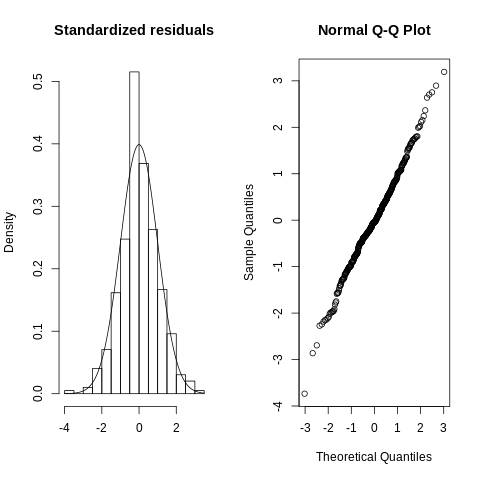

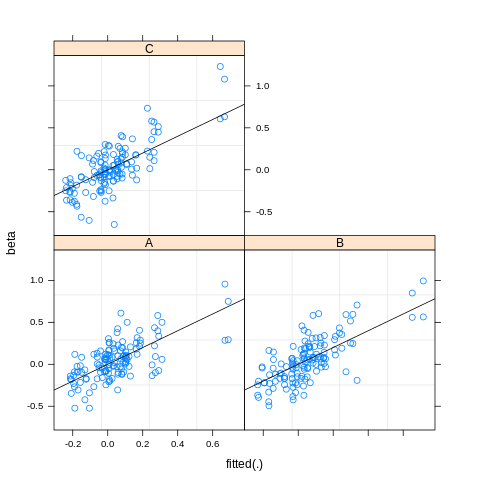

In [10]:
%%R
par(mfrow=c(1,2))
hist((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T), freq=F, main='Standardized residuals', xlab=''); curve(dnorm, add = TRUE)
qqnorm((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T))
plot(lmod)  # these plots don't appear in the jupyter notebook
plot(lmod, beta ~ fitted(.) | event_type, abline = c(0,1))
plot(lmod, beta ~ fitted(.) | subregion, abline = c(0,1))

### Repeat the t-tests and LMEMs, using the stimuli-betas as DVs

In [11]:
GLM1_betas_long2 = GLM1_betas_long.loc[GLM1_betas_long['event type'].isin(['easy', 'hard'])]
GLM1_betas_long2 = GLM1_betas_long2.rename(columns={'event type': 'event_type'})

In [12]:
%%R -i GLM1_betas_long2 -i results_difficulty -o results_difficulty
library(BayesFactor)

GLM1_betas_long2$event_type <- factor(GLM1_betas_long2$event_type)
GLM1_betas_long2$hemisphere <- factor(GLM1_betas_long2$hemisphere)
GLM1_betas_long2$subregion <- factor(GLM1_betas_long2$subregion)

b1 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'A','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'A','beta'], paired=TRUE)

b2 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'B','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'B','beta'], paired=TRUE)

b3 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'C','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'C','beta'], paired=TRUE)

b4 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'A','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'A','beta'], paired=TRUE)
b5 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'B','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'B','beta'], paired=TRUE)
b6 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'C','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'C','beta'], paired=TRUE)

print(paste0('BF10 for L A: ', extractBF(b1)$bf))
print(paste0('BF10 for L B: ', extractBF(b2)$bf))
print(paste0('BF10 for L C: ', extractBF(b3)$bf))
print(paste0('BF10 for R A: ', extractBF(b4)$bf))
print(paste0('BF10 for R B: ', extractBF(b5)$bf))
print(paste0('BF10 for R C: ', extractBF(b6)$bf))

results_difficulty$bf <- NA
results_difficulty[results_difficulty$mask == 'signal_l_A', 'bf10'] <- extractBF(b1)$bf
results_difficulty[results_difficulty$mask == 'signal_l_B', 'bf10'] <- extractBF(b2)$bf
results_difficulty[results_difficulty$mask == 'signal_l_C', 'bf10'] <- extractBF(b3)$bf
results_difficulty[results_difficulty$mask == 'signal_r_A', 'bf10'] <- extractBF(b4)$bf
results_difficulty[results_difficulty$mask == 'signal_r_B', 'bf10'] <- extractBF(b5)$bf
results_difficulty[results_difficulty$mask == 'signal_r_C', 'bf10'] <- extractBF(b6)$bf

# Models
print(generalTestBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM1_betas_long2, whichModels='all'))

lmod <- lmer(beta~event_type*subregion + (1|subject), GLM1_betas_long2) 
summary(lmod)
anova(lmod)

[1] "BF01 for L A: 0.219877151355977"
[1] "BF01 for L B: 0.198222325811562"
[1] "BF01 for L C: 0.21168676979929"
[1] "BF01 for R A: 0.2084233003476"
[1] "BF01 for R B: 0.190289741630377"
[1] "BF01 for R C: 0.2234169666616"
  |======================================================================| 100%
Bayes factor analysis
--------------
[1] event_type                                    : 0.122649     ±0%
[2] subregion                                     : 0.05778035   ±0.01%
[3] event_type:subregion                          : 0.05609191   ±0.02%
[4] event_type + subregion                        : 0.007949499  ±9.88%
[5] event_type + event_type:subregion             : 0.007020651  ±5.99%
[6] subregion + event_type:subregion              : 0.003166057  ±1.22%
[7] event_type + subregion + event_type:subregion : 0.0003803646 ±1.47%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

Type III Analysis of Variance Table with Satterthwaite's method
            

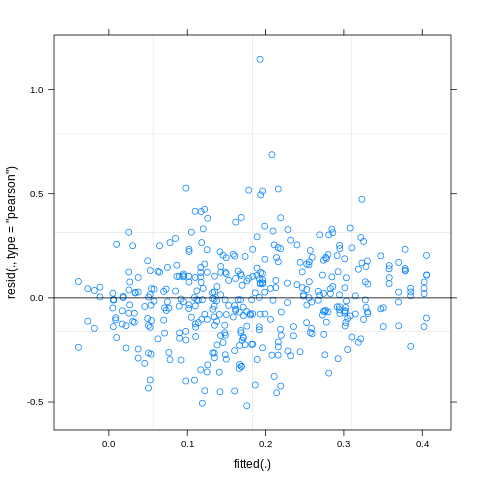

In [13]:
%%R
plot(lmod)

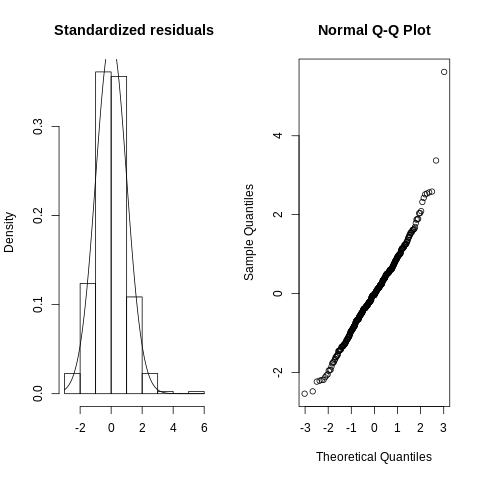

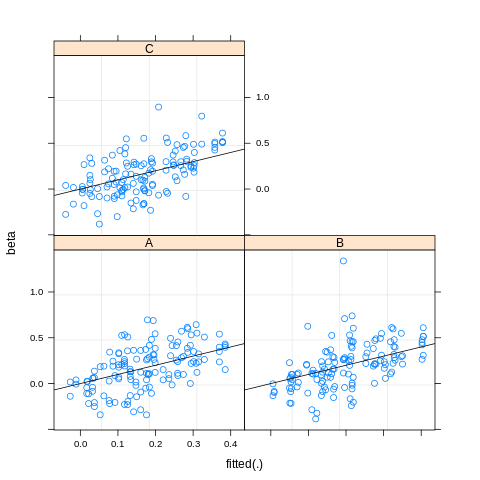

In [14]:
%%R
par(mfrow=c(1,2))
hist((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T), freq=F, main='Standardized residuals', xlab=''); curve(dnorm, add = TRUE)
qqnorm((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T))
plot(lmod)  # these plots don't appear in the jupyter notebook
plot(lmod, beta ~ fitted(.) | event_type, abline = c(0,1))
plot(lmod, beta ~ fitted(.) | subregion, abline = c(0,1))

# GLM 2

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


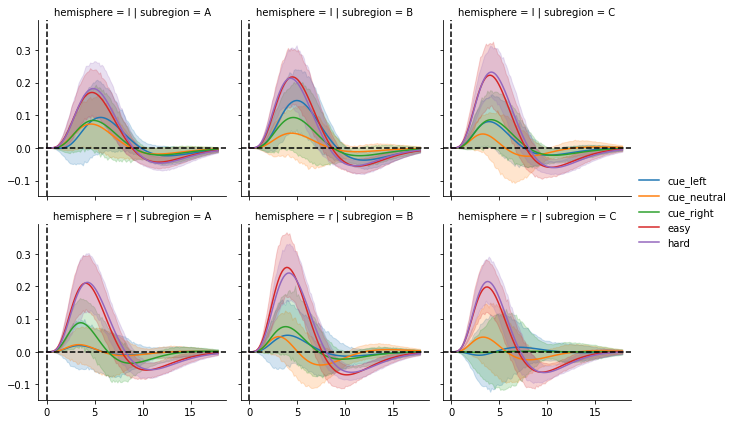

In [15]:
events_2 = events.loc[events['event_type'].isin(['easy', 'hard', 'cue_left', 'cue_right', 'cue_neutral'])].copy()

glm2 = GroupResponseFitter(df.copy(), 
                            events_2, 
                            confounds=confounds.copy(),
                            input_sample_rate=1/3, oversample_design_matrix=20, concatenate_runs=True)
for event_type in events_2.event_type.unique():
    glm2.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])
glm2.fit()

# get timecourses
tc = glm2.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('_').apply(lambda x: x[1])
tc['subregion'] = tc['roi'].str.split('_').apply(lambda x: x[2])

# plot
fac = sns.FacetGrid(tc, row='hemisphere', col='subregion')
fac.map_dataframe(sns.lineplot, x='time', hue='event type', y='signal', color=sns.color_palette())
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')
fac.add_legend()

### Statistics

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


,mask,t,p,p.fdr,contrast
0,signal_l_A,0.181918,0.856795,0.881666,glm2_cues
1,signal_l_B,1.620183,0.115007,0.690045,glm2_cues
2,signal_l_C,-0.334481,0.740199,0.881666,glm2_cues
3,signal_r_A,-0.968253,0.340180,0.881666,glm2_cues
4,signal_r_B,-0.333999,0.740559,0.881666,glm2_cues
5,signal_r_C,0.150052,0.881666,0.881666,glm2_cues


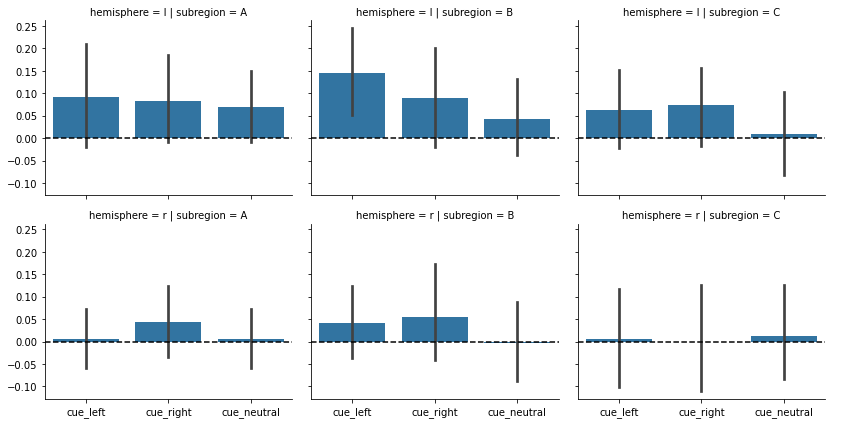

In [16]:
GLM2_betas = pd.concat(glm2.concat_response_fitters.apply(lambda x: x.betas).values)
GLM2_betas = GLM2_betas.loc[(['cue_left', 'cue_right', 'cue_neutral', 'easy', 'hard'], 'intercept', 'HRF')].reset_index(level=[1,2], drop=True)
GLM2_betas['subject'] = np.repeat(np.arange(1, 34), 5)
GLM2_betas = GLM2_betas.reset_index().set_index(['subject', 'event type'])

## long format for plotting
GLM2_betas_long = GLM2_betas.reset_index().melt(id_vars=['subject', 'event type'], var_name='roi', value_name='beta')
GLM2_betas_long['hemisphere'] = GLM2_betas_long['roi'].str.split('_').apply(lambda x: x[1])
GLM2_betas_long['subregion'] = GLM2_betas_long['roi'].str.split('_').apply(lambda x: x[2])

## Plot
fac = sns.FacetGrid(GLM2_betas_long, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['cue_left', 'cue_right', 'cue_neutral'])#, 'easy', 'hard'])
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

## statistics per ROI, single contrast
results = []
for roi in GLM2_betas_long.roi.unique():
    deg_free = GLM2_betas_long.loc[(GLM2_betas_long['roi']==roi) & (GLM2_betas_long['event type'] == 'cue_payoff'), 'beta'].shape[0] - 1
    tval, pval = scipy.stats.ttest_rel(GLM2_betas_long.loc[(GLM2_betas_long['roi']==roi) & (GLM2_betas_long['event type'] == 'cue_left'), 'beta'],
                                       GLM2_betas_long.loc[(GLM2_betas_long['roi']==roi) & (GLM2_betas_long['event type'] == 'cue_right'), 'beta'])
    #print("Subregion {}, contrast cue_left != cue_right, t({}) = {:.4f}, p = {:.4f}".format(roi, deg_free, tval, pval))
    results.append({'mask': roi, 't': tval, 'p': pval})

results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results['contrast'] = 'glm2_cues'
display(results)
results_glm2 = results.copy()

In [17]:
GLM2_betas_longR = GLM2_betas_long.loc[GLM2_betas_long['event type'].isin(['cue_left', 'cue_right'])]
GLM2_betas_longR = GLM2_betas_longR.rename(columns={'event type': 'event_type'})

GLM2_betas_longR.loc[(GLM2_betas_longR['event_type'] == 'cue_left') & (GLM2_betas_longR.roi.str.match('.*_l_*')), 'event_type2'] = 'ipsilateral'
GLM2_betas_longR.loc[(GLM2_betas_longR['event_type'] == 'cue_right') & (GLM2_betas_longR.roi.str.match('.*_l_*')), 'event_type2'] = 'contralateral'
GLM2_betas_longR.loc[(GLM2_betas_longR['event_type'] == 'cue_left') & (GLM2_betas_longR.roi.str.match('.*_r_*')), 'event_type2'] = 'contralateral'
GLM2_betas_longR.loc[(GLM2_betas_longR['event_type'] == 'cue_right') & (GLM2_betas_longR.roi.str.match('.*_r_*')), 'event_type2'] = 'ipsilateral'
GLM2_betas_longR

,subject,event_type,roi,beta,hemisphere,subregion,event_type2
0,1,cue_left,signal_l_A,0.587155,l,A,ipsilateral
4,1,cue_right,signal_l_A,0.230972,l,A,contralateral
5,2,cue_left,signal_l_A,-0.172906,l,A,ipsilateral
9,2,cue_right,signal_l_A,-0.286142,l,A,contralateral
10,3,cue_left,signal_l_A,0.123856,l,A,ipsilateral
...,...,...,...,...,...,...,...
979,31,cue_right,signal_r_C,-0.245595,r,C,ipsilateral
980,32,cue_left,signal_r_C,-0.018581,r,C,contralateral
984,32,cue_right,signal_r_C,-0.085571,r,C,ipsilateral
985,33,cue_left,signal_r_C,-0.561191,r,C,contralateral


In [18]:
%%R -i GLM2_betas_longR -i results_glm2 -o results_glm2
library(BayesFactor)
GLM2_betas_longR$laterality <- factor(GLM2_betas_longR$event_type2)
GLM2_betas_longR$hemisphere <- factor(GLM2_betas_longR$hemisphere)
GLM2_betas_longR$subregion <- factor(GLM2_betas_longR$subregion)

b1 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'A','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'A','beta'], paired=TRUE)

b2 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'B','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'B','beta'], paired=TRUE)

b3 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'C','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'C','beta'], paired=TRUE)

b4 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'A','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'A','beta'], paired=TRUE)
b5 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'B','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'B','beta'], paired=TRUE)
b6 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'C','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'C','beta'], paired=TRUE)

print(paste0('BF10 for L A: ', extractBF(b1)$bf))
print(paste0('BF10 for L B: ', extractBF(b2)$bf))
print(paste0('BF10 for L C: ', extractBF(b3)$bf))
print(paste0('BF10 for R A: ', extractBF(b4)$bf))
print(paste0('BF10 for R B: ', extractBF(b5)$bf))
print(paste0('BF10 for R C: ', extractBF(b6)$bf))

results_glm2$bf <- NA
results_glm2[results_glm2$mask == 'signal_l_A', 'bf10'] <- extractBF(b1)$bf
results_glm2[results_glm2$mask == 'signal_l_B', 'bf10'] <- extractBF(b2)$bf
results_glm2[results_glm2$mask == 'signal_l_C', 'bf10'] <- extractBF(b3)$bf
results_glm2[results_glm2$mask == 'signal_r_A', 'bf10'] <- extractBF(b4)$bf
results_glm2[results_glm2$mask == 'signal_r_B', 'bf10'] <- extractBF(b5)$bf
results_glm2[results_glm2$mask == 'signal_r_C', 'bf10'] <- extractBF(b6)$bf

# Bayes
print(generalTestBF(beta ~ 1 + laterality*subregion, whichRandom="subject", data = GLM2_betas_longR, whichModels='all'))

# Frequentist
lmod <- lmer(beta~laterality*subregion + (1|subject), GLM2_betas_longR) 
summary(lmod)
anova(lmod)

[1] "BF10 for L A: 0.189110212720216"
[1] "BF10 for L B: 0.60507662907407"
[1] "BF10 for L C: 0.196174578434986"
[1] "BF10 for R A: 0.286630123359624"
[1] "BF10 for R B: 0.196145211472646"
[1] "BF10 for R C: 0.18817997497399"
  |======================================================================| 100%
Bayes factor analysis
--------------
[1] laterality                                    : 0.1297658    ±0%
[2] subregion                                     : 0.06289158   ±0.01%
[3] laterality:subregion                          : 0.0618843    ±0.02%
[4] laterality + subregion                        : 0.008068257  ±2.29%
[5] laterality + laterality:subregion             : 0.008080448  ±2.91%
[6] subregion + laterality:subregion              : 0.003851302  ±1.7%
[7] laterality + subregion + laterality:subregion : 0.0004914413 ±2.79%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

Type III Analysis of Variance Table with Satterthwaite's method
          

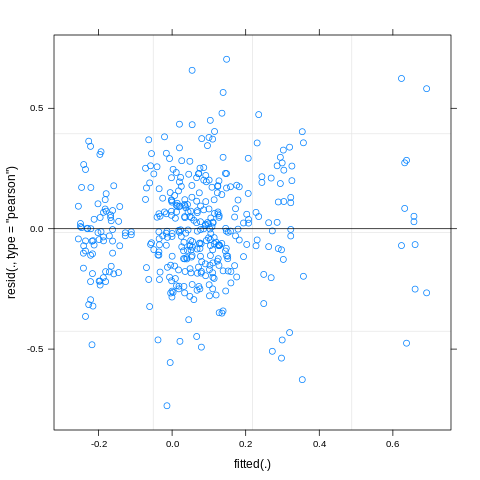

In [19]:
%%R 
plot(lmod)

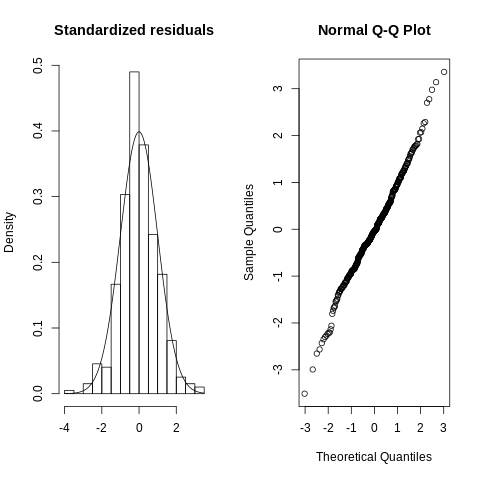

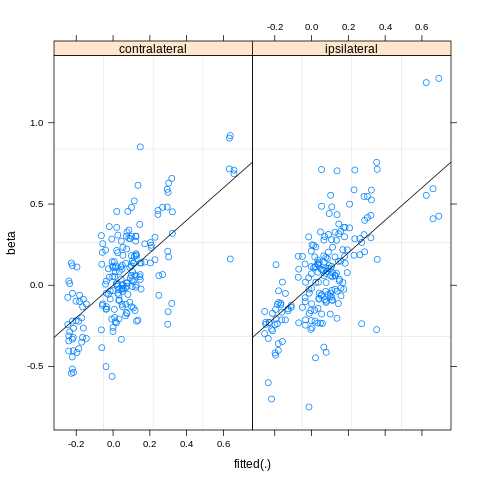

In [20]:
%%R 
par(mfrow=c(1,2))
hist((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T), freq=F, main='Standardized residuals', xlab=''); curve(dnorm, add = TRUE)
qqnorm((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T))
plot(lmod)  # these plots don't appear in the jupyter notebook
plot(lmod, beta ~ fitted(.) | laterality, abline = c(0,1))

## GLM3

In [81]:
def combine_difficulty(x):
    x['next_event'] = x['event_type'].shift(-1)
    x['event_type'] = x['event_type'] + '_' + x['next_event']
    x = x.loc[x['event_type'].isin(['easy_correct', 'easy_error', 'hard_correct', 'hard_error'])]
    return x[['onset', 'event_type', 'duration']]

tmp = events.copy().reset_index()
tmp = tmp.loc[tmp['event_type'].isin(['easy', 'hard', 'error', 'correct'])]
stim_diff = tmp.groupby(['subject', 'run']).apply(lambda x: combine_difficulty(x)).reset_index(level=2, drop=True)

tmp = events.copy()
tmp = tmp.loc[tmp['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral'])]
events_3 = pd.concat([tmp, stim_diff]).sort_values(['subject', 'run', 'onset'])

In [82]:
# def combine_difficulty_accuracy(x):
#     return '_'.join(x['event_type'].values)

# events_1c = events.copy().reset_index()
# events_1c = events_1c.loc[events_1c['event_type'].isin(['cue_payoff', 'easy', 'hard', 'cue_neutral', 'error', 'correct'])]
# events_1c = events_1c.groupby(['subject', 'run', 'onset']).apply(lambda x: combine_difficulty_accuracy(x)).reset_index().set_index(['subject', 'run'])
# events_1c = events_1c.rename(columns={0: 'event_type'})

# events_1c.loc[events_1c['event_type'].isin(['cue_left', 'cue_right']), 'event_type'] = 'cue_payoff'
# events_1c = events_1c.loc[~events_1c['event_type'].isin(['response_left', 'response_right'])]
# events_1c.head()

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/group_analysis.py:161: UserWarning: Event easy_error is not available for run (26, 2). Event is ignored for this run
  'run' % (e, col))
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/group_analysis.py:161: UserWarning: Event easy_error is not available for run (27, 1). Event is ignored for this run
  'run' % (e, col))
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/group_analysis.py:161: UserWarning: Event easy_error is not available for run (27, 2). Event is ignored for this run
  'run' % (e, col))
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/group_analysis.py:161: UserWarning: Event easy_error is not available for run (27,

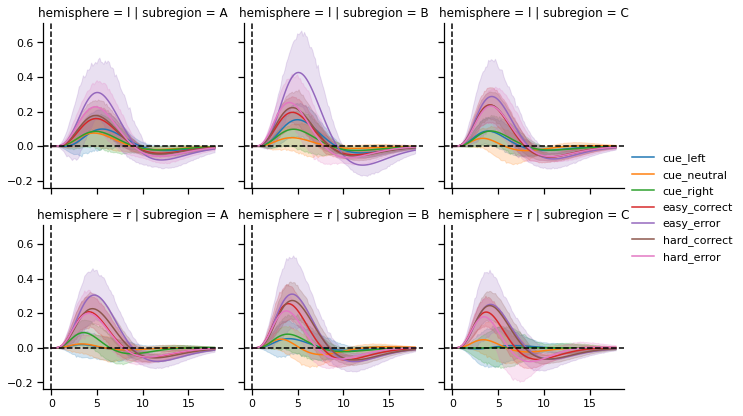

In [83]:
glm3 = GroupResponseFitter(df.copy(), 
                            events_3, 
                            confounds=confounds.copy(),
                            input_sample_rate=1/3, oversample_design_matrix=20, concatenate_runs=True)
for event_type in events_3.event_type.unique():
    glm3.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])
glm3.fit()

# get timecourses
tc = glm3.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('_').apply(lambda x: x[1])
tc['subregion'] = tc['roi'].str.split('_').apply(lambda x: x[2])

# plot
fac = sns.FacetGrid(tc, row='hemisphere', col='subregion')
fac.map_dataframe(sns.lineplot, x='time', hue='event type', y='signal', color=sns.color_palette())
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')
fac.add_legend()

In [84]:
def add_subject(x):
    betas = x.iloc[1].betas
    betas['subject'] = x.iloc[0]
    return betas

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


,mask,t,p,p.fdr,contrast
0,signal_l_A,0.651826,0.519168,0.623002,glm3
1,signal_l_B,0.684273,0.498729,0.623002,glm3
2,signal_l_C,0.095209,0.924742,0.924742,glm3
3,signal_r_A,0.981576,0.333672,0.623002,glm3
4,signal_r_B,1.343991,0.188403,0.565210,glm3
5,signal_r_C,1.774311,0.085527,0.513165,glm3


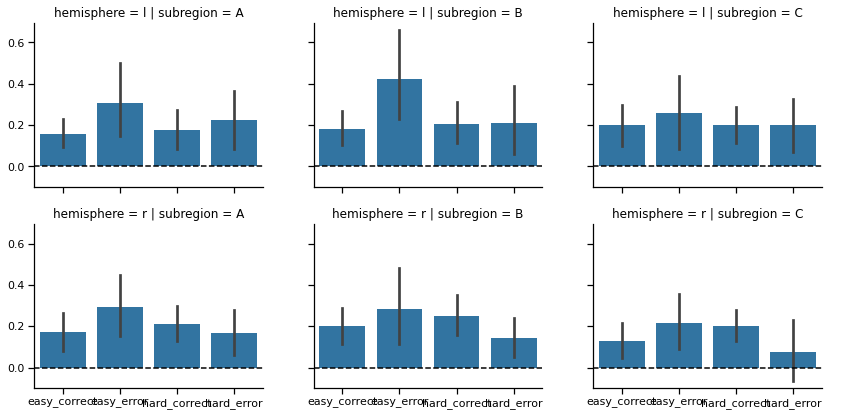

In [85]:
GLM3_betas = pd.concat(glm3.concat_response_fitters.reset_index().apply(lambda x: add_subject(x), axis=1).values)
GLM3_betas = GLM3_betas.loc[(['cue_payoff', 'cue_neutral', 'easy_correct', 'hard_correct', 'easy_error', 'hard_error'], 'intercept', 'HRF')].reset_index(level=[1,2], drop=True)
GLM3_betas = GLM3_betas.reset_index().set_index(['subject', 'event type'])

## long format for plotting
GLM3_betas_long = GLM3_betas.reset_index().melt(id_vars=['subject', 'event type'], var_name='roi', value_name='beta')
GLM3_betas_long['hemisphere'] = GLM3_betas_long['roi'].str.split('_').apply(lambda x: x[1])
GLM3_betas_long['subregion'] = GLM3_betas_long['roi'].str.split('_').apply(lambda x: x[2])

## Plot
fac = sns.FacetGrid(GLM3_betas_long, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['easy_correct', 'easy_error', 'hard_correct', 'hard_error'])
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

## statistics per ROI, single contrast
results = []
for roi in GLM3_betas_long.roi.unique():
    deg_free = GLM3_betas_long.loc[(GLM3_betas_long['roi']==roi) & (GLM3_betas_long['event type'] == 'cue_payoff'), 'beta'].shape[0] - 1
    tval, pval = scipy.stats.ttest_rel(GLM3_betas_long.loc[(GLM3_betas_long['roi']==roi) & (GLM3_betas_long['event type'] == 'hard_correct'), 'beta'],
                                       GLM3_betas_long.loc[(GLM3_betas_long['roi']==roi) & (GLM3_betas_long['event type'] == 'easy_correct'), 'beta'])
    results.append({'mask': roi, 't': tval, 'p': pval})
    
results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results['contrast'] = 'glm3'
results_glm3 = results.copy()
display(results)

In [86]:
GLM3_betas_longR = GLM3_betas_long.loc[GLM3_betas_long['event type'].isin(['hard_correct', 'easy_correct'])]
GLM3_betas_longR = GLM3_betas_longR.rename(columns={'event type': 'event_type'})

In [87]:
%%R -i GLM3_betas_longR -i results_glm3 -o results_glm3
library(BayesFactor)
GLM3_betas_longR$event_type <- factor(GLM3_betas_longR$event_type)
GLM3_betas_longR$hemisphere <- factor(GLM3_betas_longR$hemisphere)
GLM3_betas_longR$subregion <- factor(GLM3_betas_longR$subregion)

b1 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'A','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'A','beta'], paired=TRUE)

b2 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'B','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'B','beta'], paired=TRUE)

b3 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'C','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'C','beta'], paired=TRUE)

b4 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'A','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'A','beta'], paired=TRUE)
b5 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'B','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'B','beta'], paired=TRUE)
b6 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'C','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'C','beta'], paired=TRUE)

results_glm3[results_glm3$mask == 'signal_l_A', 'bf10'] <- extractBF(b1)$bf
results_glm3[results_glm3$mask == 'signal_l_B', 'bf10'] <- extractBF(b2)$bf
results_glm3[results_glm3$mask == 'signal_l_C', 'bf10'] <- extractBF(b3)$bf
results_glm3[results_glm3$mask == 'signal_r_A', 'bf10'] <- extractBF(b4)$bf
results_glm3[results_glm3$mask == 'signal_r_B', 'bf10'] <- extractBF(b5)$bf
results_glm3[results_glm3$mask == 'signal_r_C', 'bf10'] <- extractBF(b6)$bf

print(paste0('BF10 for L A: ', extractBF(b1)$bf))
print(paste0('BF10 for L B: ', extractBF(b2)$bf))
print(paste0('BF10 for L C: ', extractBF(b3)$bf))
print(paste0('BF10 for R A: ', extractBF(b4)$bf))
print(paste0('BF10 for R B: ', extractBF(b5)$bf))
print(paste0('BF10 for R C: ', extractBF(b6)$bf))

# Bayes
print(generalTestBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM3_betas_longR, whichModels='all'))

# Frequentist
lmod <- lmer(beta~event_type*subregion + (1|subject), GLM3_betas_longR) 
summary(lmod)
anova(lmod)

[1] "BF10 for L A: 0.226751614822455"
[1] "BF10 for L B: 0.231322069614155"
[1] "BF10 for L C: 0.187003350839704"
[1] "BF10 for R A: 0.290026729161956"
[1] "BF10 for R B: 0.423005342739746"
[1] "BF10 for R C: 0.757366816707209"
  |======================================================================| 100%
Bayes factor analysis
--------------
[1] event_type                                    : 0.2592573    ±0%
[2] subregion                                     : 0.04646841   ±0.01%
[3] event_type:subregion                          : 0.05281961   ±0.02%
[4] event_type + subregion                        : 0.01176479   ±1.26%
[5] event_type + event_type:subregion             : 0.01300587   ±1.19%
[6] subregion + event_type:subregion              : 0.002425982  ±1.67%
[7] event_type + subregion + event_type:subregion : 0.0005922363 ±1.34%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

Type III Analysis of Variance Table with Satterthwaite's method
       

## What about accuracy x difficulty?

In [88]:
GLM3_betas_longR2 = GLM3_betas_long.loc[GLM3_betas_long['event type'].isin(['hard_correct', 'easy_correct', 'hard_error', 'easy_error'])]
GLM3_betas_longR2 = GLM3_betas_longR2.rename(columns={'event type': 'event_type'})
GLM3_betas_longR2['difficulty'] = GLM3_betas_longR2['event_type'].apply(lambda x: x.split('_')[0])
GLM3_betas_longR2['accuracy'] = GLM3_betas_longR2['event_type'].apply(lambda x: x.split('_')[1])

Type III Analysis of Variance Table with Satterthwaite's method
                     Sum Sq Mean Sq NumDF  DenDF F value    Pr(>F)    
accuracy            0.37093 0.37093     1 750.91  3.2771 0.0706519 .  
difficulty          0.43933 0.43933     1 750.91  3.8814 0.0491914 *  
accuracy:difficulty 1.30506 1.30506     1 750.91 11.5299 0.0007208 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


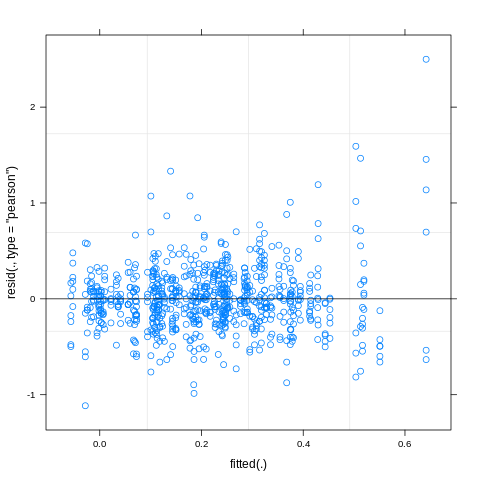

In [89]:
%%R -i GLM3_betas_longR2
library(BayesFactor)
library(lme4)
library(lmerTest)

# GLM3_betas_longR2$difficulty <- factor(GLM3_betas_longR2$difficulty)
# GLM3_betas_longR2$accuracy <- factor(GLM3_betas_longR2$accuracy)
#GLM3_betas_longR_ <- GLM3_betas_longR2[-c(79,  94, 209, 216, 218, 340, 356, 582, 618, 621),]
GLM3_betas_longR2$difficulty <- factor(GLM3_betas_longR2$difficulty)
GLM3_betas_longR2$accuracy <- factor(GLM3_betas_longR2$accuracy)

lmod <- lmer(beta~accuracy*difficulty + (1|subject), GLM3_betas_longR2)
summary(lmod)
print(anova(lmod))
plot(lmod)

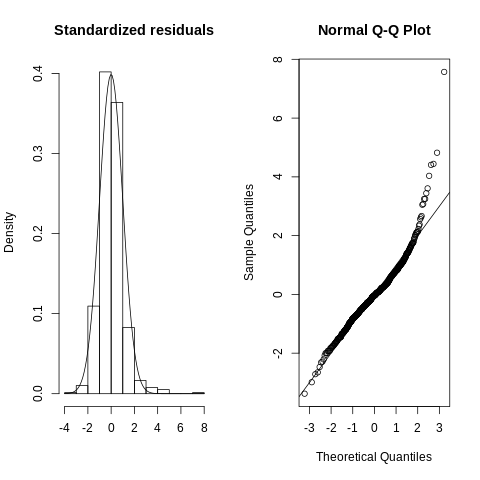

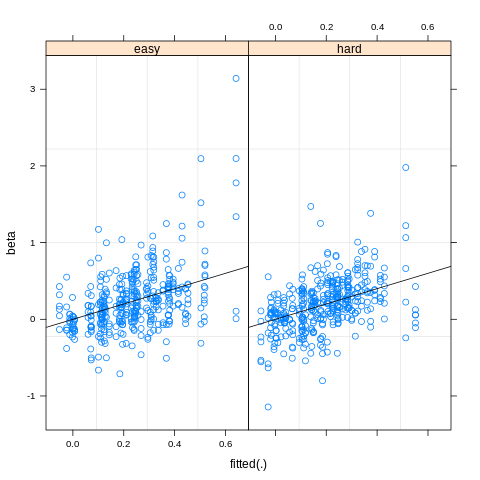

In [90]:
%%R
par(mfrow=c(1,2))
standardized_res = (resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T)
hist(standardized_res, freq=F, main='Standardized residuals', xlab=''); curve(dnorm, add = TRUE)
qqnorm(standardized_res)
abline(a=0,b=1)
plot(lmod)  # these plots don't appear in the jupyter notebook
plot(lmod, beta ~ fitted(.) | accuracy, abline = c(0,1))
plot(lmod, beta ~ fitted(.) | difficulty, abline = c(0,1))

#### The interaction appears significant, but the assumption checks look terrible (highly non-Gaussian, right-skewed residuals) Quite some subjects have very few errors in the easy condition, which leads to a very unstable beta-estimate. Let's see what the results look like when we only consider subs with >= 15 of these datapoints

In [91]:
counts = events_3.groupby(level=0).event_type.value_counts()#.reset_index()
counts.name = 'count'
counts = counts.reset_index()
drop_subs = counts.loc[(counts['event_type'] == 'easy_error') & (counts['count'] < 15), 'subject'].values

In [92]:
GLM3_betas_long_excl = GLM3_betas_long.copy()
GLM3_betas_long_excl = GLM3_betas_long_excl.loc[~(GLM3_betas_long_excl.subject.isin(drop_subs))]

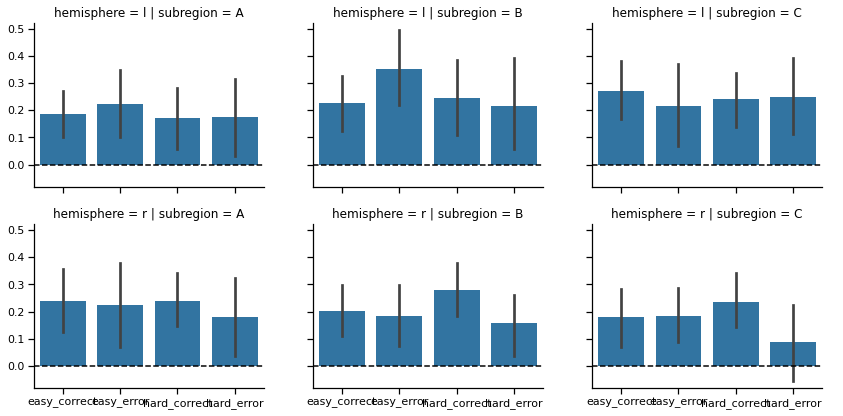

In [93]:
## Plot
fac = sns.FacetGrid(GLM3_betas_long_excl, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['easy_correct', 'easy_error', 'hard_correct', 'hard_error'])
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

In [94]:
GLM3_betas_long_excl = GLM3_betas_long_excl.rename(columns={'event type': 'event_type'})
GLM3_betas_long_excl['difficulty'] = GLM3_betas_long_excl['event_type'].apply(lambda x: x.split('_')[0])
GLM3_betas_long_excl['accuracy'] = GLM3_betas_long_excl['event_type'].apply(lambda x: x.split('_')[1])


Interpret type III hypotheses with care.



Type III Analysis of Variance Table with Satterthwaite's method
                    Sum Sq Mean Sq NumDF  DenDF F value    Pr(>F)    
accuracy            4.5836 2.29182     2 657.61 30.0385 3.284e-13 ***
difficulty          0.0413 0.04133     1 658.10  0.5417    0.4620    
accuracy:difficulty 0.1631 0.16308     1 658.10  2.1375    0.1442    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


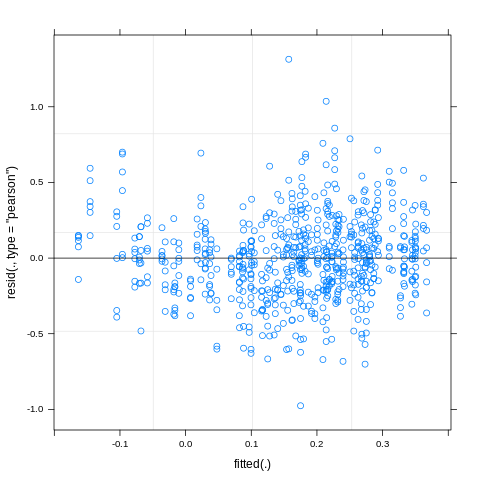

In [95]:
%%R -i GLM3_betas_long_excl
library(BayesFactor)
library(lme4)
library(lmerTest)

# GLM3_betas_long_excl$difficulty <- factor(GLM3_betas_long_excl$difficulty)
# GLM3_betas_long_excl$accuracy <- factor(GLM3_betas_long_excl$accuracy)
#GLM3_betas_longR_ <- GLM3_betas_long_excl[-c(79,  94, 209, 216, 218, 340, 356, 582, 618, 621),]
GLM3_betas_long_excl$difficulty <- factor(GLM3_betas_long_excl$difficulty)
GLM3_betas_long_excl$accuracy <- factor(GLM3_betas_long_excl$accuracy)

lmod <- lmer(beta~accuracy*difficulty + (1|subject), GLM3_betas_long_excl)
summary(lmod)
print(anova(lmod))
plot(lmod)

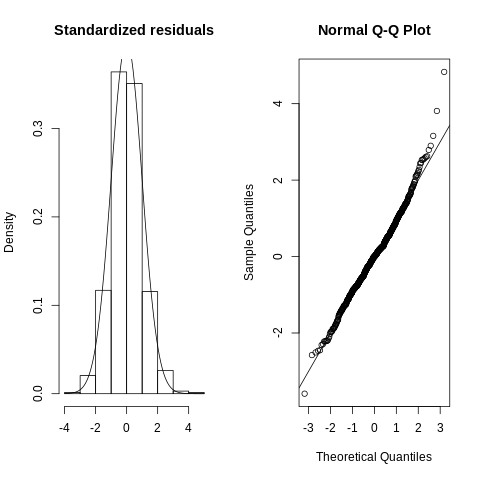

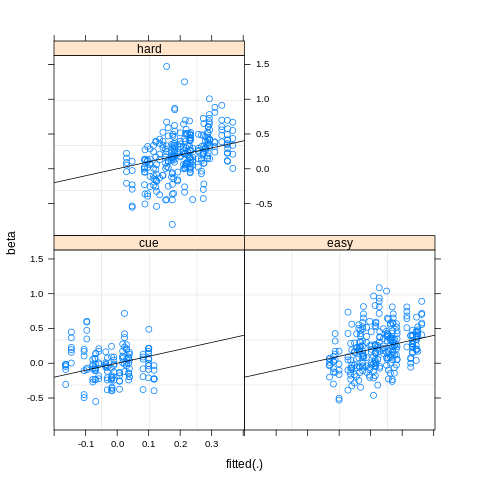

In [96]:
%%R
par(mfrow=c(1,2))
standardized_res = (resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T)
hist(standardized_res, freq=F, main='Standardized residuals', xlab=''); curve(dnorm, add = TRUE)
qqnorm(standardized_res)
abline(a=0,b=1)
plot(lmod)  # these plots don't appear in the jupyter notebook
plot(lmod, beta ~ fitted(.) | accuracy, abline = c(0,1))
plot(lmod, beta ~ fitted(.) | difficulty, abline = c(0,1))

#### Residuals look (a bit) better now, and the interaction effect is gone

# GLM4

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


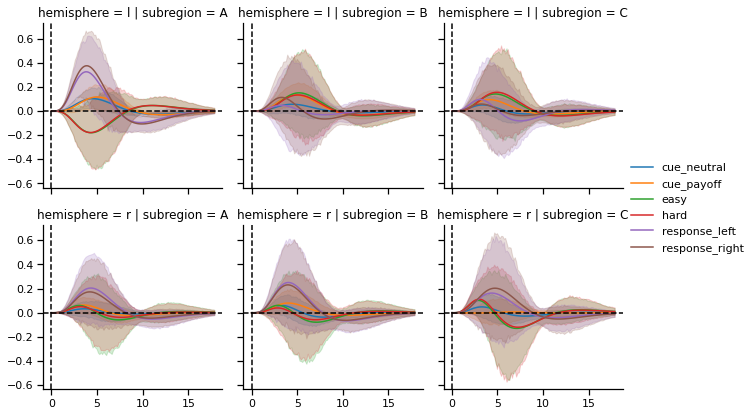

In [97]:
events_4 = events.loc[events['event_type'].isin(['easy', 'hard', 'cue_left', 'cue_right', 'cue_neutral', 'response_left', 'response_right'])]
events_4.loc[events_4['event_type'].isin(['cue_left', 'cue_right']), 'event_type'] = 'cue_payoff'

glm4 = GroupResponseFitter(df.copy(), 
                            events_4, 
                            confounds=confounds,
                            input_sample_rate=1/3, oversample_design_matrix=20, concatenate_runs=True)
for event_type in events_4.event_type.unique():
    glm4.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])

glm4.fit()

# get timecourses
tc = glm4.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('_').apply(lambda x: x[1])
tc['subregion'] = tc['roi'].str.split('_').apply(lambda x: x[2])

# plot
fac = sns.FacetGrid(tc, row='hemisphere', col='subregion')
fac.map_dataframe(sns.lineplot, x='time', hue='event type', y='signal', color=sns.color_palette())
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')
fac.add_legend()

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


,mask,t,p,p.fdr,contrast
0,signal_l_A,-1.338884,0.190043,0.380085,glm4
1,signal_l_B,-0.541354,0.592013,0.657797,glm4
2,signal_l_C,-0.447124,0.657797,0.657797,glm4
3,signal_r_A,1.350186,0.186429,0.380085,glm4
4,signal_r_B,0.518987,0.607340,0.657797,glm4
5,signal_r_C,-1.539881,0.133421,0.380085,glm4


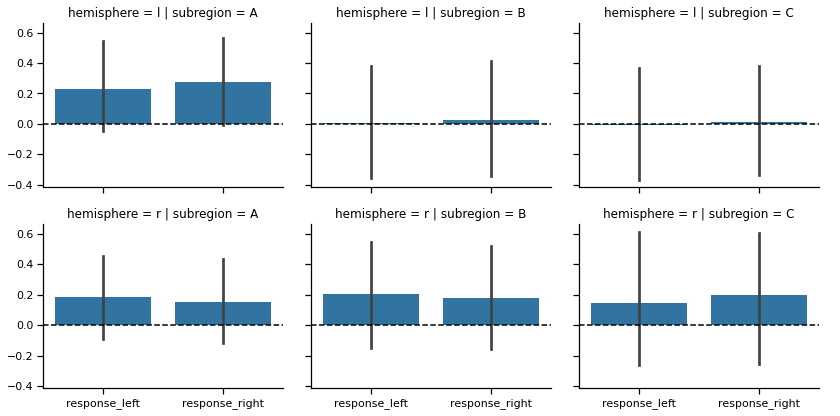

In [98]:
GLM4_betas = pd.concat(glm4.concat_response_fitters.reset_index().apply(lambda x: add_subject(x), axis=1).values)
GLM4_betas = GLM4_betas.loc[(['response_left', 'response_right'], 'intercept', 'HRF')].reset_index(level=[1,2], drop=True)
GLM4_betas = GLM4_betas.reset_index().set_index(['subject', 'event type'])

## long format for plotting
GLM4_betas_long = GLM4_betas.reset_index().melt(id_vars=['subject', 'event type'], var_name='roi', value_name='beta')
GLM4_betas_long['hemisphere'] = GLM4_betas_long['roi'].str.split('_').apply(lambda x: x[1])
GLM4_betas_long['subregion'] = GLM4_betas_long['roi'].str.split('_').apply(lambda x: x[2])

## Plot
fac = sns.FacetGrid(GLM4_betas_long, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['response_left', 'response_right'])
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

## statistics per ROI, single contrast
results = []
for roi in GLM4_betas_long.roi.unique():
    deg_free = GLM4_betas_long.loc[(GLM4_betas_long['roi']==roi) & (GLM4_betas_long['event type'] == 'cue_payoff'), 'beta'].shape[0] - 1
    tval, pval = scipy.stats.ttest_rel(GLM4_betas_long.loc[(GLM4_betas_long['roi']==roi) & (GLM4_betas_long['event type'] == 'response_left'), 'beta'],
                                       GLM4_betas_long.loc[(GLM4_betas_long['roi']==roi) & (GLM4_betas_long['event type'] == 'response_right'), 'beta'])
    results.append({'mask': roi, 't': tval, 'p': pval})
    
results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results['contrast'] = 'glm4'
results_glm4 = results.copy()
display(results)

In [99]:
GLM4_betas_longR = GLM4_betas_long.loc[GLM4_betas_long['event type'].isin(['response_left', 'response_right'])]
GLM4_betas_longR = GLM4_betas_longR.rename(columns={'event type': 'event_type'})

GLM4_betas_longR.loc[(GLM4_betas_longR['event_type'] == 'response_left') & (GLM4_betas_longR.roi.str.match('.*_l_*')), 'event_type2'] = 'ipsilateral'
GLM4_betas_longR.loc[(GLM4_betas_longR['event_type'] == 'response_right') & (GLM4_betas_longR.roi.str.match('.*_l_*')), 'event_type2'] = 'contralateral'
GLM4_betas_longR.loc[(GLM4_betas_longR['event_type'] == 'response_left') & (GLM4_betas_longR.roi.str.match('.*_r_*')), 'event_type2'] = 'contralateral'
GLM4_betas_longR.loc[(GLM4_betas_longR['event_type'] == 'response_right') & (GLM4_betas_longR.roi.str.match('.*_r_*')), 'event_type2'] = 'ipsilateral'
GLM4_betas_longR

,subject,event_type,roi,beta,hemisphere,subregion,event_type2
0,1,response_left,signal_l_A,0.794127,l,A,ipsilateral
1,1,response_right,signal_l_A,0.828448,l,A,contralateral
2,2,response_left,signal_l_A,0.205110,l,A,ipsilateral
3,2,response_right,signal_l_A,0.279927,l,A,contralateral
4,3,response_left,signal_l_A,2.097030,l,A,ipsilateral
...,...,...,...,...,...,...,...
391,32,response_right,signal_r_C,0.222421,r,C,ipsilateral
392,33,response_left,signal_r_C,0.077370,r,C,contralateral
393,33,response_right,signal_r_C,0.144131,r,C,ipsilateral
394,34,response_left,signal_r_C,-0.156297,r,C,contralateral


In [100]:
%%R -i GLM4_betas_longR -i results_glm4 -o results_glm4
library(BayesFactor)
GLM4_betas_longR$event_type <- factor(GLM4_betas_longR$event_type)
GLM4_betas_longR$hemisphere <- factor(GLM4_betas_longR$hemisphere)
GLM4_betas_longR$subregion <- factor(GLM4_betas_longR$subregion)

b1 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'A','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'A','beta'], paired=TRUE)

b2 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'B','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'B','beta'], paired=TRUE)

b3 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'C','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'C','beta'], paired=TRUE)

b4 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'A','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'A','beta'], paired=TRUE)
b5 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'B','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'B','beta'], paired=TRUE)
b6 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'C','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'C','beta'], paired=TRUE)

#results_glm4$bf <- NA
results_glm4[results_glm4$mask == 'signal_l_A', 'bf10'] <- extractBF(b1)$bf
results_glm4[results_glm4$mask == 'signal_l_B', 'bf10'] <- extractBF(b2)$bf
results_glm4[results_glm4$mask == 'signal_l_C', 'bf10'] <- extractBF(b3)$bf
results_glm4[results_glm4$mask == 'signal_r_A', 'bf10'] <- extractBF(b4)$bf
results_glm4[results_glm4$mask == 'signal_r_B', 'bf10'] <- extractBF(b5)$bf
results_glm4[results_glm4$mask == 'signal_r_C', 'bf10'] <- extractBF(b6)$bf

print(paste0('BF10 for L A: ', extractBF(b1)$bf))
print(paste0('BF10 for L B: ', extractBF(b2)$bf))
print(paste0('BF10 for L C: ', extractBF(b3)$bf))
print(paste0('BF10 for R A: ', extractBF(b4)$bf))
print(paste0('BF10 for R B: ', extractBF(b5)$bf))
print(paste0('BF10 for R C: ', extractBF(b6)$bf))

# ipsi/contralateral coding
GLM4_betas_longR$event_type <- factor(GLM4_betas_longR$event_type2)

# Bayes
print(generalTestBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM4_betas_longR, whichModels='all'))

# Frequentist
lmod <- lmer(beta~event_type*subregion + (1|subject), GLM4_betas_longR) 
summary(lmod)
anova(lmod)

[1] "BF10 for L A: 0.420448840761655"
[1] "BF10 for L B: 0.213368434055869"
[1] "BF10 for L C: 0.204360834378804"
[1] "BF10 for R A: 0.426139398964912"
[1] "BF10 for R B: 0.211040380407501"
[1] "BF10 for R C: 0.54200904751134"
  |======================================================================| 100%
Bayes factor analysis
--------------
[1] event_type                                    : 0.11227      ±0%
[2] subregion                                     : 0.04586945   ±0.01%
[3] event_type:subregion                          : 0.05311777   ±0.02%
[4] event_type + subregion                        : 0.005144891  ±3.94%
[5] event_type + event_type:subregion             : 0.00591331   ±1.72%
[6] subregion + event_type:subregion              : 0.002386448  ±1.54%
[7] event_type + subregion + event_type:subregion : 0.0002903921 ±9.94%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

Type III Analysis of Variance Table with Satterthwaite's method
        

## No differences between subregions

# Plot

In [102]:
f.savefig('figures/figure4_size.pdf', bbox_inches='tight')

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


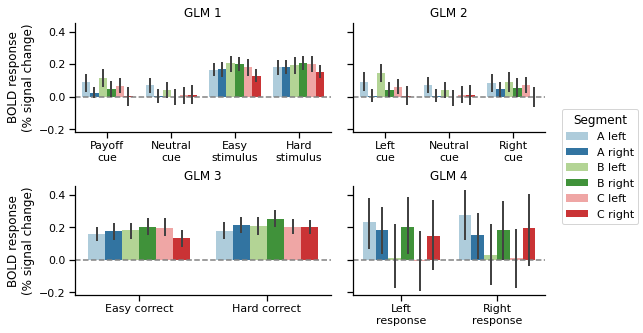

In [159]:
sns.set_context('notebook')
font = {'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

ci = 67

f = plt.figure(figsize=(9,5))
gridspec = f.add_gridspec(ncols=2, nrows=2, 
                          wspace=.1, hspace=0.5,
                          width_ratios=[4,3])
# left/right
ax0 = f.add_subplot(gridspec[0,0])
ax1 = f.add_subplot(gridspec[0,1], sharey=ax0)
ax2 = f.add_subplot(gridspec[1,0], sharey=ax0)
ax3 = f.add_subplot(gridspec[1,1], sharey=ax0)
ax = [ax0, ax1, ax2, ax3]

# f, ax = plt.subplots(1,4)#,  sharey='row')
for ax_ in ax:
    ax_.axhline(0, color='grey', linestyle='--')

b1 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM1_betas_long, 
                 ax=ax[0], ci=ci, errwidth=2, #capsize=.05,
                 order=['cue_payoff', 'cue_neutral', 'easy', 'hard'],
                 hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
h, l = ax[0].get_legend_handles_labels() #.remove()
b1.legend_.remove()
ax[0].set_xticklabels(['Payoff\ncue', 'Neutral\ncue', 'Easy\nstimulus', 'Hard\nstimulus'])
ax[0].set_title('GLM 1')
ax[0].set_ylabel('BOLD response\n(% signal change)')

b2 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM2_betas_long,
                 ax=ax[1], ci=ci, errwidth=2,
                 order=['cue_left', 'cue_neutral', 'cue_right'],
                 hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
b2.legend_.remove()
ax[1].set_xticklabels(['Left\ncue', 'Neutral\ncue', 'Right\ncue'])#, rotation=30, ha='right')
ax[1].set_title('GLM 2')

b3 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM3_betas_long.loc[GLM3_betas_long['event type'].isin(['easy_correct', 'hard_correct'])],
                 ax=ax[2], ci=ci, errwidth=2,
                 order=['easy_correct', 'hard_correct'],
                 hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
b3.legend_.remove()
ax[2].set_xticklabels(['Easy correct', 'Hard correct'])#, rotation=30, ha='right')
ax[2].set_title('GLM 3')
#ax[2].set_ylabel('BOLD response\n(% signal change)')

b4 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM4_betas_long,
                 ax=ax[3], ci=ci,errwidth=2, 
                 order=['response_left', 'response_right'],
                 hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
b4.legend_.remove()
ax[3].set_title('GLM 4')
ax[3].set_xticklabels(['Left\nresponse', 'Right\nresponse'])
#ax[3].yaxis.set_ticklabels([])

ax[3].tick_params(labelleft=False)
ax[1].tick_params(labelleft=False)
#ax[2].yaxis.set_ticklabels([])

for ax_ in ax:
    ax_.set_xlabel('')
for ax_ in [ax[1], ax[3]]:
    ax_.set_ylabel('')
ax[2].set_ylabel('BOLD response\n(% signal change)')

sns.despine()

f.tight_layout()
f.legend(h, ['A left', 'A right', 'B left', 'B right', 'C left', 'C right'], loc='center right', title='Segment')
f.subplots_adjust(right=.85)
#f.set_size_inches(15,4)

In [160]:
f.savefig('figures/figure4_size_fixedylabel.pdf', bbox_inches='tight')

Table 1 in paper

In [119]:
all_stats = pd.concat([results_cue, results_difficulty, results_glm2, results_glm3, results_glm4])
all_stats['bf01'] = 1/all_stats['bf10']

In [156]:
table1_full = all_stats.melt(id_vars=['mask', 'contrast'], value_vars=['t', 'p', 'p.fdr', 'bf01']).pivot_table(values='value', index='mask', columns=['contrast', 'variable']).round(3)

In [157]:
table1_paper = table1_full.iloc[:, table1_full.columns.get_level_values(1).isin(['t', 'bf01'])]
table1_paper.round(2)

contrast   glm1_cue       glm1_difficulty       glm2_cues        glm3        \
variable       bf01     t            bf01     t      bf01     t  bf01     t   
mask                                                                          
signal_l_A     4.62  0.57            4.55 -0.60      5.29  0.18  4.41  0.65   
signal_l_B     0.77  2.11            5.04  0.37      1.65  1.62  4.32  0.68   
signal_l_C     0.61  2.24            4.72 -0.52      5.10 -0.33  5.35  0.10   
signal_r_A     3.73  0.89            4.80 -0.49      3.49 -0.97  3.45  0.98   
signal_r_B     1.92  1.51            5.26 -0.22      5.10 -0.33  2.36  1.34   
signal_r_C     5.18 -0.28            4.48 -0.63      5.31  0.15  1.32  1.77   

contrast    glm4        
variable    bf01     t  
mask                    
signal_l_A  2.38 -1.34  
signal_l_B  4.69 -0.54  
signal_l_C  4.89 -0.45  
signal_r_A  2.35  1.35  
signal_r_B  4.74  0.52  
signal_r_C  1.84 -1.54

In [2]:
# can we get 95% CI errorbars?

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


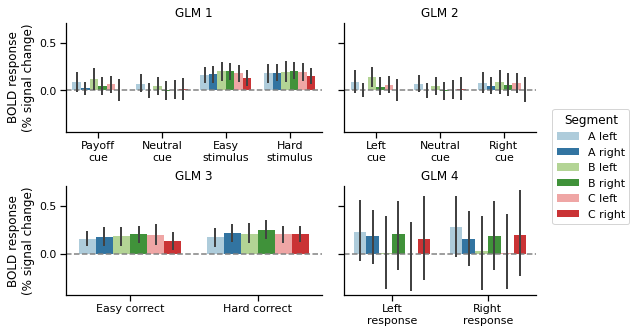

In [158]:
sns.set_context('notebook')
font = {'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

ci = 95

f = plt.figure(figsize=(9,5))
gridspec = f.add_gridspec(ncols=2, nrows=2, 
                          wspace=.1, hspace=0.5,
                          width_ratios=[4,3])
# left/right
ax0 = f.add_subplot(gridspec[0,0])
ax1 = f.add_subplot(gridspec[0,1], sharey=ax0)
ax2 = f.add_subplot(gridspec[1,0], sharey=ax0)
ax3 = f.add_subplot(gridspec[1,1], sharey=ax0)
ax = [ax0, ax1, ax2, ax3]

# f, ax = plt.subplots(1,4)#,  sharey='row')
for ax_ in ax:
    ax_.axhline(0, color='grey', linestyle='--')

b1 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM1_betas_long, 
                 ax=ax[0], ci=ci, errwidth=2, #capsize=.05,
                 order=['cue_payoff', 'cue_neutral', 'easy', 'hard'],
                 hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
h, l = ax[0].get_legend_handles_labels() #.remove()
b1.legend_.remove()
ax[0].set_xticklabels(['Payoff\ncue', 'Neutral\ncue', 'Easy\nstimulus', 'Hard\nstimulus'])
ax[0].set_title('GLM 1')
ax[0].set_ylabel('BOLD response\n(% signal change)')

b2 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM2_betas_long,
                 ax=ax[1], ci=ci, errwidth=2,
                 order=['cue_left', 'cue_neutral', 'cue_right'],
                 hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
b2.legend_.remove()
ax[1].set_xticklabels(['Left\ncue', 'Neutral\ncue', 'Right\ncue'])#, rotation=30, ha='right')
ax[1].set_title('GLM 2')

b3 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM3_betas_long.loc[GLM3_betas_long['event type'].isin(['easy_correct', 'hard_correct'])],
                 ax=ax[2], ci=ci, errwidth=2,
                 order=['easy_correct', 'hard_correct'],
                 hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
b3.legend_.remove()
ax[2].set_xticklabels(['Easy correct', 'Hard correct'])#, rotation=30, ha='right')
ax[2].set_title('GLM 3')
#ax[2].set_ylabel('BOLD response\n(% signal change)')

b4 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM4_betas_long,
                 ax=ax[3], ci=ci,errwidth=2, 
                 order=['response_left', 'response_right'],
                 hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
b4.legend_.remove()
ax[3].set_title('GLM 4')
ax[3].set_xticklabels(['Left\nresponse', 'Right\nresponse'])
#ax[3].yaxis.set_ticklabels([])

ax[3].tick_params(labelleft=False)
ax[1].tick_params(labelleft=False)
#ax[2].yaxis.set_ticklabels([])

for ax_ in ax:
    ax_.set_xlabel('')
for ax_ in [ax[1], ax[3]]:
    ax_.set_ylabel('')
ax[2].set_ylabel('BOLD response\n(% signal change)')

sns.despine()

f.tight_layout()
f.legend(h, ['A left', 'A right', 'B left', 'B right', 'C left', 'C right'], loc='center right', title='Segment')
f.subplots_adjust(right=.85)
#f.set_size_inches(15,4)

In [3]:
# this messes up the height of the y-axis...

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


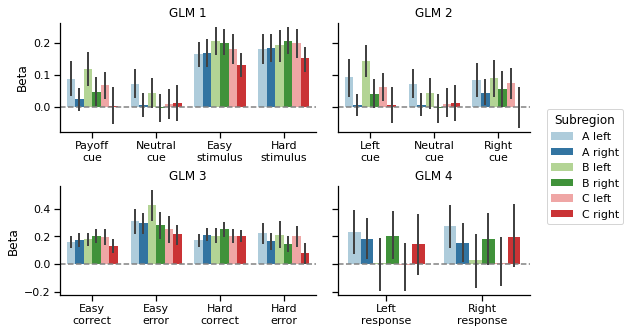

In [101]:
# sns.set_context('notebook')
# font = {'size'   : 14}
# import matplotlib
# matplotlib.rc('font', **font)

# f = plt.figure(figsize=(9,5))
# gridspec = f.add_gridspec(ncols=2, nrows=2, 
#                           wspace=.1, hspace=0.5,
#                           width_ratios=[4,3])
# # left/right
# ax0 = f.add_subplot(gridspec[0,0])
# ax1 = f.add_subplot(gridspec[0,1], sharey=ax0)
# ax2 = f.add_subplot(gridspec[1,0])
# ax3 = f.add_subplot(gridspec[1,1], sharey=ax2)
# ax = [ax0, ax1, ax2, ax3]

# # f, ax = plt.subplots(1,4)#,  sharey='row')
# for ax_ in ax:
#     ax_.axhline(0, color='grey', linestyle='--')

# b1 = sns.barplot(x='event type', y='beta', hue='roi',
#                  palette=sns.color_palette("Paired"),
#                  data=GLM1_betas_long, 
#                  ax=ax[0], ci=67, errwidth=2, #capsize=.05,
#                  order=['cue_payoff', 'cue_neutral', 'easy', 'hard'],
#                  hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
# h, l = ax[0].get_legend_handles_labels() #.remove()
# b1.legend_.remove()
# ax[0].set_xticklabels(['Payoff\ncue', 'Neutral\ncue', 'Easy\nstimulus', 'Hard\nstimulus'])
# ax[0].set_title('GLM 1')
# ax[0].set_ylabel('Beta')

# b2 = sns.barplot(x='event type', y='beta', hue='roi',
#                  palette=sns.color_palette("Paired"),
#                  data=GLM2_betas_long,
#                  ax=ax[1], ci=67, errwidth=2,
#                  order=['cue_left', 'cue_neutral', 'cue_right'],
#                  hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
# b2.legend_.remove()
# ax[1].set_xticklabels(['Left\ncue', 'Neutral\ncue', 'Right\ncue'])#, rotation=30, ha='right')
# ax[1].set_title('GLM 2')

# b3 = sns.barplot(x='event type', y='beta', hue='roi',
#                  palette=sns.color_palette("Paired"),
#                  data=GLM3_betas_long,
#                  ax=ax[2], ci=67, errwidth=2,
#                  order=['easy_correct', 'easy_error', 'hard_correct', 'hard_error'],
#                  hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
# b3.legend_.remove()
# ax[2].set_xticklabels(['Easy\ncorrect', 'Easy\nerror', 'Hard\ncorrect', 'Hard\nerror'])#, rotation=30, ha='right')
# ax[2].set_title('GLM 3')
# ax[2].set_ylabel('Beta')

# b4 = sns.barplot(x='event type', y='beta', hue='roi',
#                  palette=sns.color_palette("Paired"),
#                  data=GLM4_betas_long,
#                  ax=ax[3], ci=67,errwidth=2, 
#                  order=['response_left', 'response_right'],
#                  hue_order=['signal_l_A', 'signal_r_A', 'signal_l_B', 'signal_r_B', 'signal_l_C', 'signal_r_C'])
# b4.legend_.remove()
# ax[3].set_title('GLM 4')
# ax[3].set_xticklabels(['Left\nresponse', 'Right\nresponse'])
# #ax[3].yaxis.set_ticklabels([])

# ax[3].tick_params(labelleft=False)
# ax[1].tick_params(labelleft=False)
# #ax[2].yaxis.set_ticklabels([])


# for ax_ in ax:
#     ax_.set_xlabel('')
# for ax_ in [ax[1], ax[3]]:
#     ax_.set_ylabel('')
# ax[2].set_ylabel('Beta')

# sns.despine()

# f.tight_layout()
# f.legend(h, ['A left', 'A right', 'B left', 'B right', 'C left', 'C right'], loc='center right', title='Subregion')
# f.subplots_adjust(right=.85)
# #f.set_size_inches(15,4)
